In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
# 对一阶差分后的序列做白噪声检验
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

In [2]:
def draw_moving(timeSeries, size):
    fig, ax = plt.subplots(1,1)
    rol_mean = timeSeries.rolling(window=size).mean()
    rol_weighted_mean = timeSeries.ewm(halflife=size, min_periods=0, adjust=True, ignore_na=False).mean()
    timeSeries.plot(color='C0', label='Original', ax=ax)
    rol_mean.plot(color='C1', label='Rolling Mean', ax=ax)
    rol_weighted_mean.plot(color='black', label='Weighted Rolling Mean', ax=ax)
    ax.legend(loc='best')
    ax.set_title('Rolling Mean')
    ax.set_xticklabels([])
    ax.set_xlabel('time')
    plt.show()

# Dickey-Fuller test:  就是得出adf检验的结果，但是显示的样式更加好看一点
def test_stationarity(ts):
    adftest = adfuller(ts)  # 返回的结果有四组键值对
    adf_output = pd.Series(adftest[0:4],
                           index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in adftest[4].items():
        adf_output['Critical Value (%s)' % key] = value
    return adf_output
 
 
# 模型平稳后，就开始确定p,q的值，先画出ACF和PACF的图像
def draw_acf_pacf(ts, lags):
    f = plt.figure(facecolor='white')
 
    ax1 = f.add_subplot(211)  # 画一组占两行一列的图
    plot_acf(ts, ax=ax1, lags=lags)
 
    ax2 = f.add_subplot(212)
    plot_pacf(ts, ax=ax2, lags=lags)
 
    plt.subplots_adjust(hspace=0.5)
    plt.show()

In [3]:
# 读取数据，pd.read_csv默认生成DataFrame对象，需将其转换成Series对象
df = pd.read_csv('task-3-result/results.csv', encoding='utf-8', index_col='frame')
df.index = pd.to_datetime(df.index) 
ts = (df['lsidedist'] + df['rsidedist']) / 2  # 生成pd.Series对象
print(test_stationarity(ts))

Test Statistic                 -2.795218
p-value                         0.058960
#Lags Used                      2.000000
Number of Observations Used    97.000000
Critical Value (1%)            -3.499637
Critical Value (5%)            -2.891831
Critical Value (10%)           -2.582928
dtype: float64


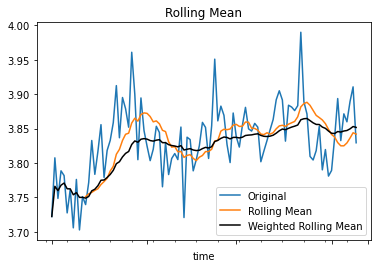

In [4]:
ts_log = np.log(ts)
draw_moving(ts_log,12)

Test Statistic                -5.835695e+00
p-value                        3.881364e-07
#Lags Used                     1.100000e+01
Number of Observations Used    7.600000e+01
Critical Value (1%)           -3.519481e+00
Critical Value (5%)           -2.900395e+00
Critical Value (10%)          -2.587498e+00
dtype: float64


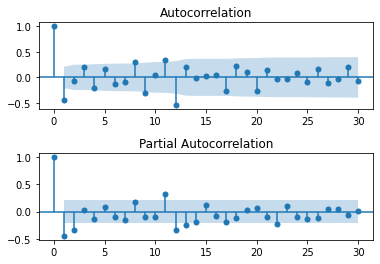

In [5]:
rol_mean = ts_log.rolling(window=10).mean()
rol_mean.dropna(inplace=True)
ts_diff_1 = rol_mean.diff(1)
ts_diff_1.dropna(inplace=True)
print(test_stationarity(ts_diff_1))
 
ts_diff_2 = ts_diff_1.diff(1)
ts_diff_2.dropna(inplace=True)
 
draw_acf_pacf(ts_diff_2,30)

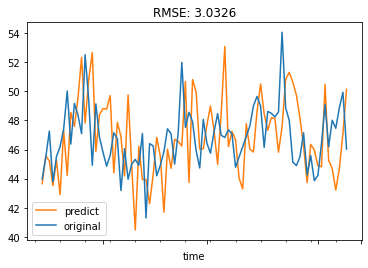

In [6]:
model = ARIMA(ts_diff_1, order=(1,1,1))
result_arima = model.fit( disp=-1, method='css')
 
predict_ts = result_arima.predict()
# 一阶差分还原
diff_shift_ts = ts_diff_1.shift(1)
diff_recover_1 = predict_ts.add(diff_shift_ts)
# 再次一阶差分还原
rol_shift_ts = rol_mean.shift(1)
diff_recover = diff_recover_1.add(rol_shift_ts)
# 移动平均还原
rol_sum = ts_log.rolling(window=11).sum()
rol_recover = diff_recover*12 - rol_sum.shift(1)
# 对数还原
log_recover = np.exp(rol_recover)
log_recover.dropna(inplace=True)
ts = ts[log_recover.index]  # 过滤没有预测的记录plt.figure(facecolor='white')
fig, ax = plt.subplots(1,1)
log_recover.plot(color='C1', label='predict', ax=ax)
ts.plot(color='C0', label='original', ax=ax)
ax.legend(loc='best')
ax.set_title('RMSE: %.4f'% np.sqrt(sum((log_recover-ts)**2)/ts.size))
ax.set_xticklabels([])
ax.set_xlabel('time')
plt.show()